Celem moich analiz jest znalezienie najważniejszych predyktorów cen biletów w Indiach.

Oraz zamodelowanie tak danych, aby można było przewidywać ceny biletów z dokładnością do 2500 rupi indyjskich (? jednostka monetarna nie została podana, więc założyłem, że może chodzić o ich walutę; przelicznik plus/minus się zgadza).

Został wybrany taki a nie inny błąd, gdyż odpowiada to mniej więcej 0,1 średniej ceny biletów (rząd wielkości mniejszy od średniej wydaje się wystarczającym przybliżeniem ceny).

In [3]:
# import wszystkich bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.figsize"] = (16,9)
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
# Set notebook mode to work in offline
pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default='colab'
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
import time
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [1]:
#import biblioteki i pliku danych z dysku googla
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# wczytanie danych dotyczących cen lotów (zródło: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction)
dane_df = pd.read_csv(r"/content/drive/MyDrive/Classroom/dataset.csv")
dane_df

Unnamed: 0   airline   flight source_city departure_time stops  \
0                0  SpiceJet  SG-8709       Delhi        Evening  zero   
1                1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2                2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3                3   Vistara   UK-995       Delhi        Morning  zero   
4                4   Vistara   UK-963       Delhi        Morning  zero   
...            ...       ...      ...         ...            ...   ...   
300148      300148   Vistara   UK-822     Chennai        Morning   one   
300149      300149   Vistara   UK-826     Chennai      Afternoon   one   
300150      300150   Vistara   UK-832     Chennai  Early_Morning   one   
300151      300151   Vistara   UK-828     Chennai  Early_Morning   one   
300152      300152   Vistara   UK-822     Chennai        Morning   one   

         arrival_time destination_city     class  duration  days_left  price  
0               Night           Mumbai   Economy      2.17          1   5953  
1             Morning           Mumbai   Economy      2.33          1   5953  
2       Early_Morning           Mumbai   Economy      2.17          1   5956  
3           Afternoon           Mumbai   Economy      2.25          1   5955  
4             Morning           Mumbai   Economy      2.33          1   5955  
...               ...              ...       ...       ...        ...    ...  
300148        Evening        Hyderabad  Business     10.08         49  69265  
300149          Night        Hyderabad  Business     10.42         49  77105  
300150          Night        Hyderabad  Business     13.83         49  79099  
300151        Evening        Hyderabad  Business     10.00         49  81585  
300152        Evening        Hyderabad  Business     10.08         49  81585  

[300153 rows x 12 columns]

In [5]:
# rozmiar ramki danych
dane_df.shape

(300153, 12)

In [6]:
dane_df.describe()

Unnamed: 0       duration      days_left          price
count  300153.000000  300153.000000  300153.000000  300153.000000
mean   150076.000000      12.221021      26.004751   20889.660523
std     86646.852011       7.191997      13.561004   22697.767366
min         0.000000       0.830000       1.000000    1105.000000
25%     75038.000000       6.830000      15.000000    4783.000000
50%    150076.000000      11.250000      26.000000    7425.000000
75%    225114.000000      16.170000      38.000000   42521.000000
max    300152.000000      49.830000      49.000000  123071.000000

In [7]:
dane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [8]:
# wstępna analiza
{
    "liczba pobranych lotów": dane_df.shape[0],
    "liczba unikalnych ID ofert": dane_df["Unnamed: 0"].nunique(),
    "liczba unikalnych linii lotniczy": dane_df["airline"].nunique(),
    "liczba unikalnych lotów": dane_df["flight"].unique(),
    "liczba unikalnych miejscowości startowych": dane_df["source_city"].nunique(),
    "unikalne miejscowości startowych": dane_df["source_city"].unique(),
    "liczba unikalnych miejscowości końcowych": dane_df["destination_city"].nunique(),\
    "unikalne miejscowości końcowe": dane_df["destination_city"].unique(),
    "stops": dane_df["stops"].unique(),
    "arrival_time": dane_df["arrival_time"].nunique(),
    "departure_time": dane_df["departure_time"].nunique(),
    "class": dane_df["class"].nunique(),
    "arrival_time": dane_df["arrival_time"].nunique(),
    "średnia czas": dane_df["duration"].mean(),
    "minimalna cza": dane_df["duration"].min(),
    "maksymalna czas": dane_df["duration"].max(),
    "średnia cena": dane_df["price"].mean(),
    "minimalna cena": dane_df["price"].min(),
    "maksymalna cena": dane_df["price"].max(),
    "średnia dni przed": dane_df["days_left"].mean(),
    "minimalna dni przed": dane_df["days_left"].min(),
    "maksymalna dni przed": dane_df["days_left"].max()
}



{'liczba pobranych lotów': 300153,
 'liczba unikalnych ID ofert': 300153,
 'liczba unikalnych linii lotniczy': 6,
 'liczba unikalnych lotów': array(['SG-8709', 'SG-8157', 'I5-764', ..., '6E-7127', '6E-7259',
        'AI-433'], dtype=object),
 'liczba unikalnych miejscowości startowych': 6,
 'unikalne miejscowości startowych': array(['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai'],
       dtype=object),
 'liczba unikalnych miejscowości końcowych': 6,
 'unikalne miejscowości końcowe': array(['Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai', 'Delhi'],
       dtype=object),
 'stops': array(['zero', 'one', 'two_or_more'], dtype=object),
 'arrival_time': 6,
 'departure_time': 6,
 'class': 2,
 'średnia czas': 12.221020812718846,
 'minimalna cza': 0.83,
 'maksymalna czas': 49.83,
 'średnia cena': 20889.660523133203,
 'minimalna cena': 1105,
 'maksymalna cena': 123071,
 'średnia dni przed': 26.004750910369044,
 'minimalna dni przed': 1,
 'maksymalna dni przed': 49}

In [9]:
#ilość lotów na każde miasto
dane_df["source_city"].value_counts(dropna=False)

Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64

In [10]:
#średnia cena z każdego miasta
dane_df.groupby("source_city").agg(dict(price = "mean")).sort_values(by = "price", ascending = False)

price
source_city              
Chennai      21995.339871
Kolkata      21746.235679
Mumbai       21483.818839
Bangalore    21469.460575
Hyderabad    20155.623879
Delhi        18951.326639

In [ ]:
#sprawdzenie czy w datasetcie są jakieś prakujące dane
dane_df.isnull().values.any()

False

<Axes: xlabel='source_city', ylabel='price'>

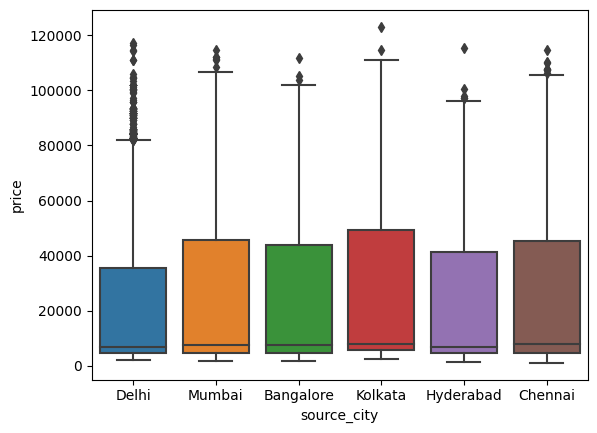

In [11]:
# analiza ceny wg. miasta starowego
sns.boxplot(data=dane_df, x="source_city", y="price", dodge=False)

<Axes: xlabel='price', ylabel='airline'>

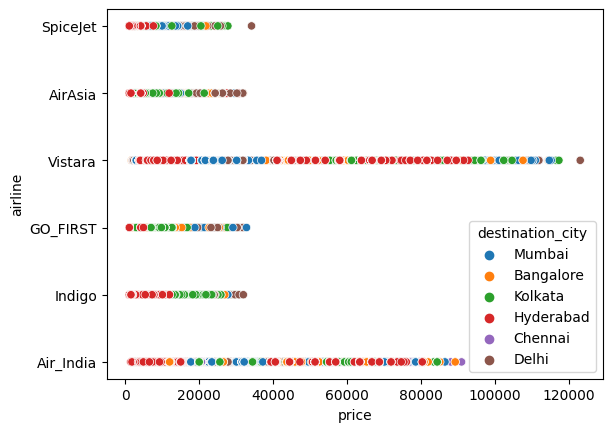

In [12]:
# analiza ofert pod kątem ceny i lini lotniczych
sns.scatterplot(data=dane_df, x="price", y="airline", hue="destination_city")

<Axes: xlabel='price', ylabel='duration'>

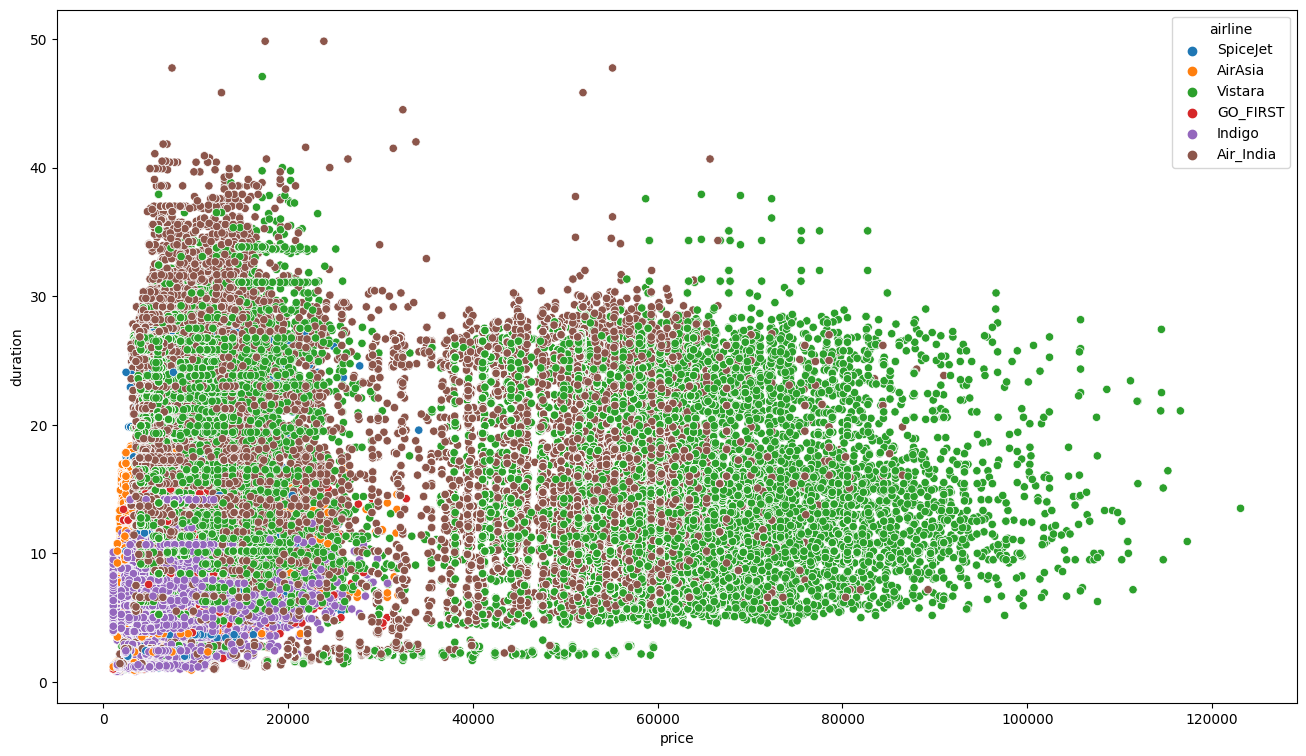

In [97]:
#cena a długość lotu
sns.scatterplot(data=dane_df, x="price", y="duration", hue="airline")

<Axes: xlabel='price', ylabel='Count'>

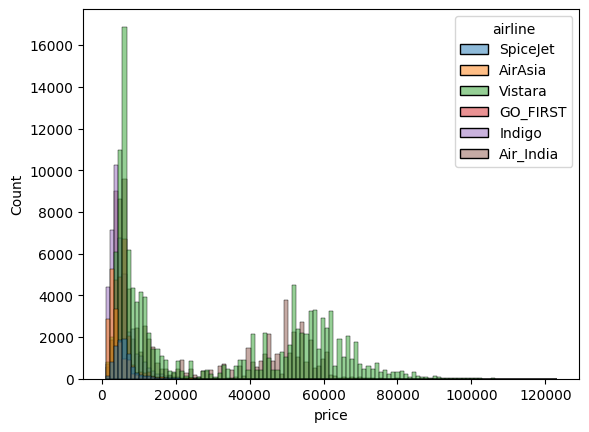

In [14]:
#cena w zależności od lini lotniczych
sns.histplot(data=dane_df, x="price", hue="airline")

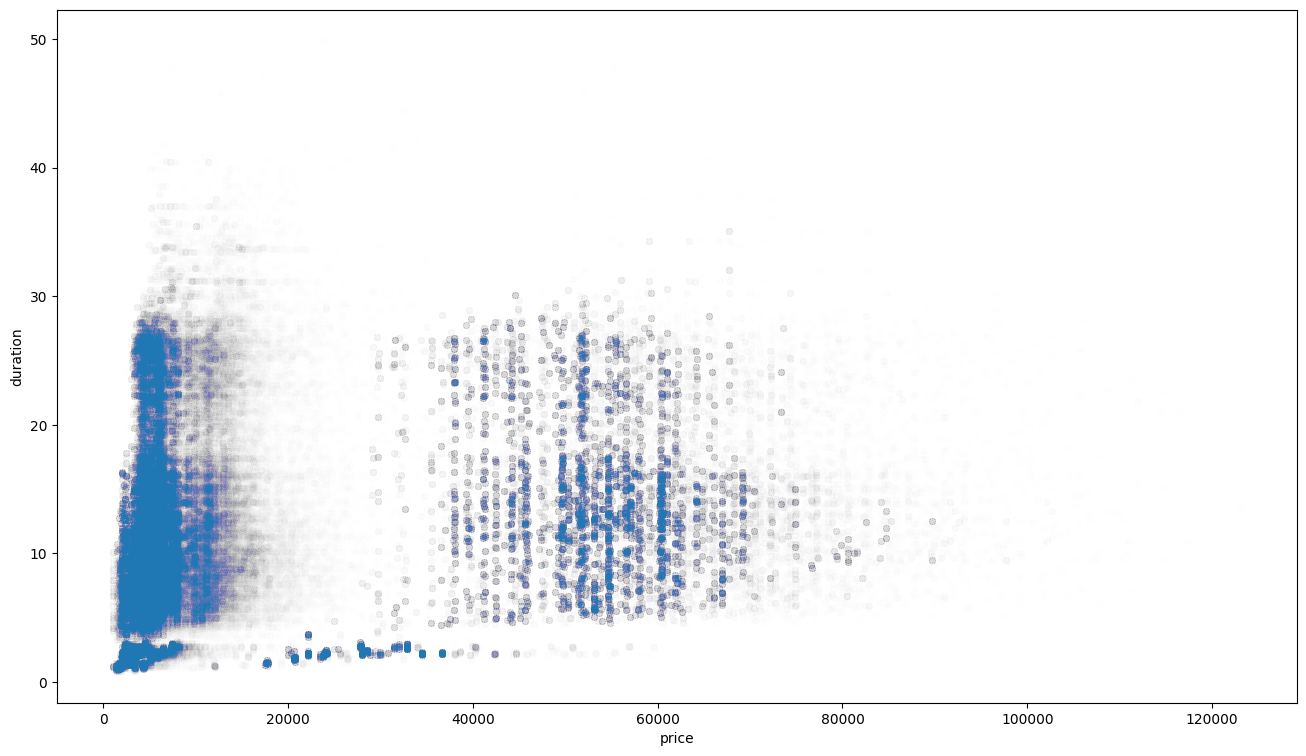

In [15]:
#cena a długość lotu - zagęszczenie
dane_df.plot(kind = "scatter",
               x = "price",
               y = "duration",
               alpha = .005);

In [16]:
# definiowanie cech do modelowania
cechy_do_modelowania = ["airline", "flight", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class",	"duration",	"days_left", "price"]
dane_modelowanie = dane_df[cechy_do_modelowania]
dane_modelowanie

airline   flight source_city departure_time stops   arrival_time  \
0       SpiceJet  SG-8709       Delhi        Evening  zero          Night   
1       SpiceJet  SG-8157       Delhi  Early_Morning  zero        Morning   
2        AirAsia   I5-764       Delhi  Early_Morning  zero  Early_Morning   
3        Vistara   UK-995       Delhi        Morning  zero      Afternoon   
4        Vistara   UK-963       Delhi        Morning  zero        Morning   
...          ...      ...         ...            ...   ...            ...   
300148   Vistara   UK-822     Chennai        Morning   one        Evening   
300149   Vistara   UK-826     Chennai      Afternoon   one          Night   
300150   Vistara   UK-832     Chennai  Early_Morning   one          Night   
300151   Vistara   UK-828     Chennai  Early_Morning   one        Evening   
300152   Vistara   UK-822     Chennai        Morning   one        Evening   

       destination_city     class  duration  days_left  price  
0                Mumbai   Economy      2.17          1   5953  
1                Mumbai   Economy      2.33          1   5953  
2                Mumbai   Economy      2.17          1   5956  
3                Mumbai   Economy      2.25          1   5955  
4                Mumbai   Economy      2.33          1   5955  
...                 ...       ...       ...        ...    ...  
300148        Hyderabad  Business     10.08         49  69265  
300149        Hyderabad  Business     10.42         49  77105  
300150        Hyderabad  Business     13.83         49  79099  
300151        Hyderabad  Business     10.00         49  81585  
300152        Hyderabad  Business     10.08         49  81585  

[300153 rows x 11 columns]

In [ ]:
dane_modelowanie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


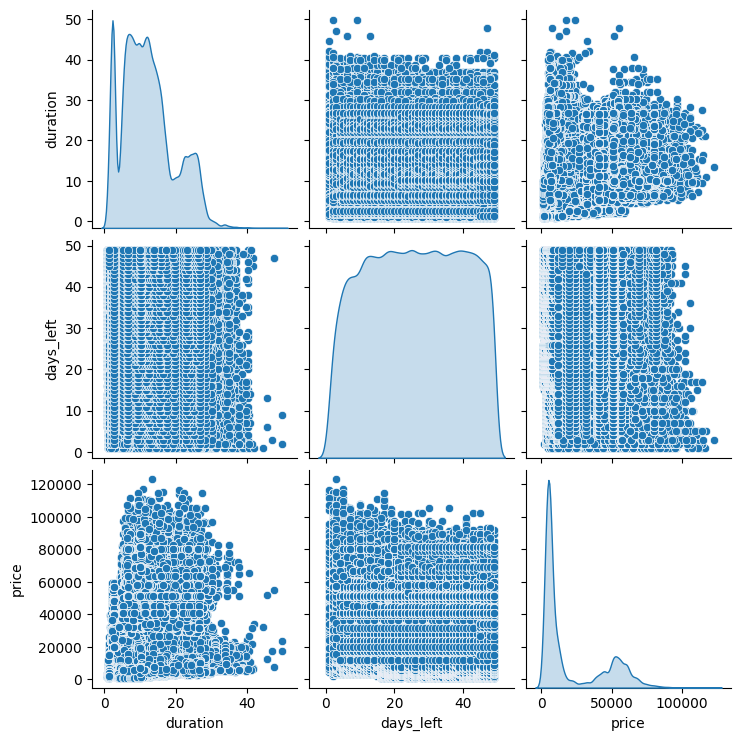

In [17]:
# wykres zależności między cechami
sns.pairplot(dane_modelowanie, diag_kind="kde");

In [23]:
px.box(dane_modelowanie, x = "price", title = "Rozrzut cechy - cena", orientation = "h")

In [24]:
px.box(dane_modelowanie, x = "duration", title = "Rozrzut cechy - czas lotu", orientation = "h")

In [25]:
px.box(dane_modelowanie, x = "days_left", title = "Rozrzut cechy - zakup X dni przed", orientation = "h")

In [26]:
def IQR_outliers(a):
    Q1, Q3 = np.percentile(a, [5, 95])
    IQR = Q3 - Q1

    gorne_ograniczenie  = Q3 +  0.5 * IQR
    dolne_ograniczenie  = Q1
    print("Górne ograniczenie:", gorne_ograniczenie)
    print("Dolne ograniczenie:", dolne_ograniczenie)

    indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
    b = np.full(shape=a.shape[0], fill_value=1)
    b[indeksy] = -1

    return b

# użycie funkcji
dane_modelowanie["flaga_IQR"] = IQR_outliers(dane_modelowanie["price"])
print(dane_modelowanie["flaga_IQR"])

Górne ograniczenie: 93697.5
Dolne ograniczenie: 2436.0
0         1
1         1
2         1
3         1
4         1
         ..
300148    1
300149    1
300150    1
300151    1
300152    1
Name: flaga_IQR, Length: 300153, dtype: int64


<Axes: xlabel='price', ylabel='duration'>

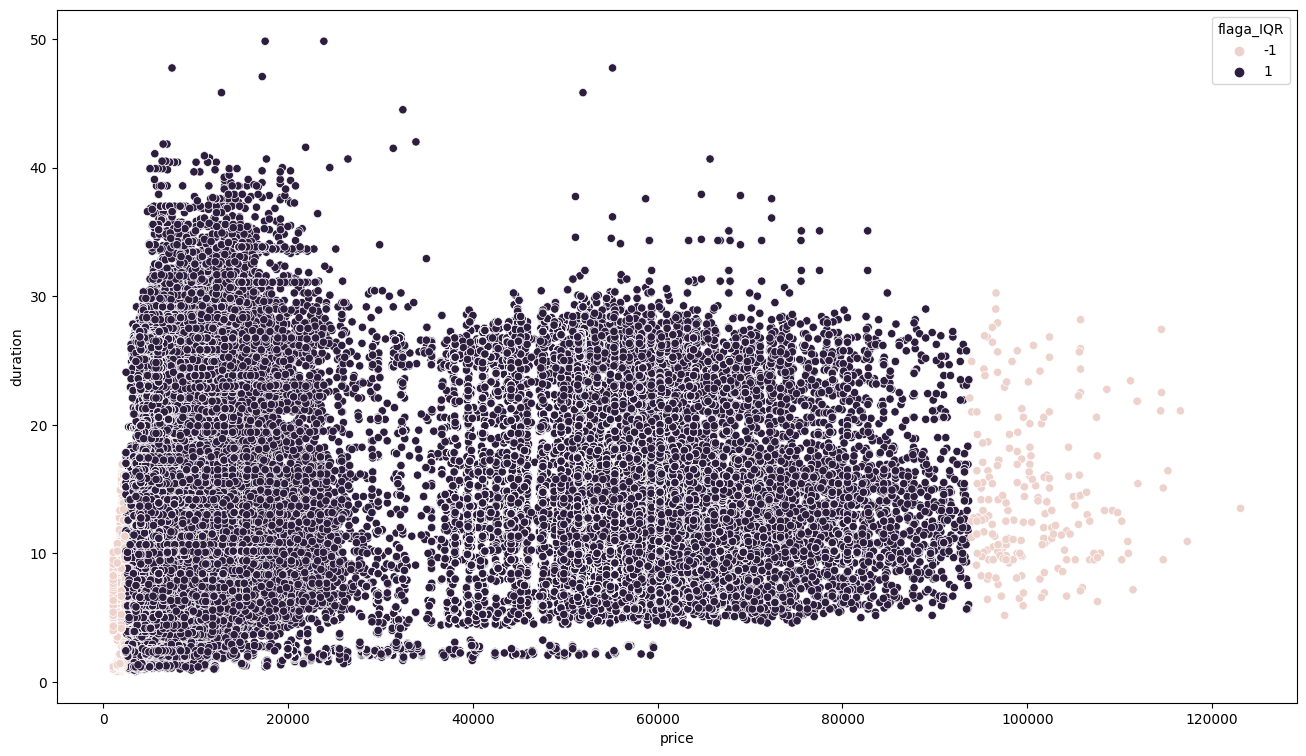

In [98]:
#co zostało usunięte?

sns.scatterplot(dane_modelowanie,
           x = "price",
           y = "duration",
           hue = "flaga_IQR")

In [28]:
dane_modelowanie_2 = dane_modelowanie[dane_modelowanie["flaga_IQR"]==1]
dane_modelowanie_2.shape

(284998, 12)

In [29]:
def IQR_outliers_2(a):
    Q1, Q3 = np.percentile(a, [25, 75])
    IQR = Q3 - Q1

    gorne_ograniczenie  = Q3 + (2.0 * IQR)
    dolne_ograniczenie  = Q1 - (2.0 * IQR)
    print("Górne ograniczenie:", gorne_ograniczenie)
    print("Dolne ograniczenie:", dolne_ograniczenie)

    indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
    b = np.full(shape=a.shape[0], fill_value=1)
    b[indeksy] = -1

    return b

Górne ograniczenie: 35.0
Dolne ograniczenie: -11.25
0         1
1         1
2         1
3         1
4         1
         ..
300148    1
300149    1
300150    1
300151    1
300152    1
Name: flaga_IQR, Length: 284998, dtype: int64


<ipython-input-30-b0308f0b1aac>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='price', ylabel='duration'>

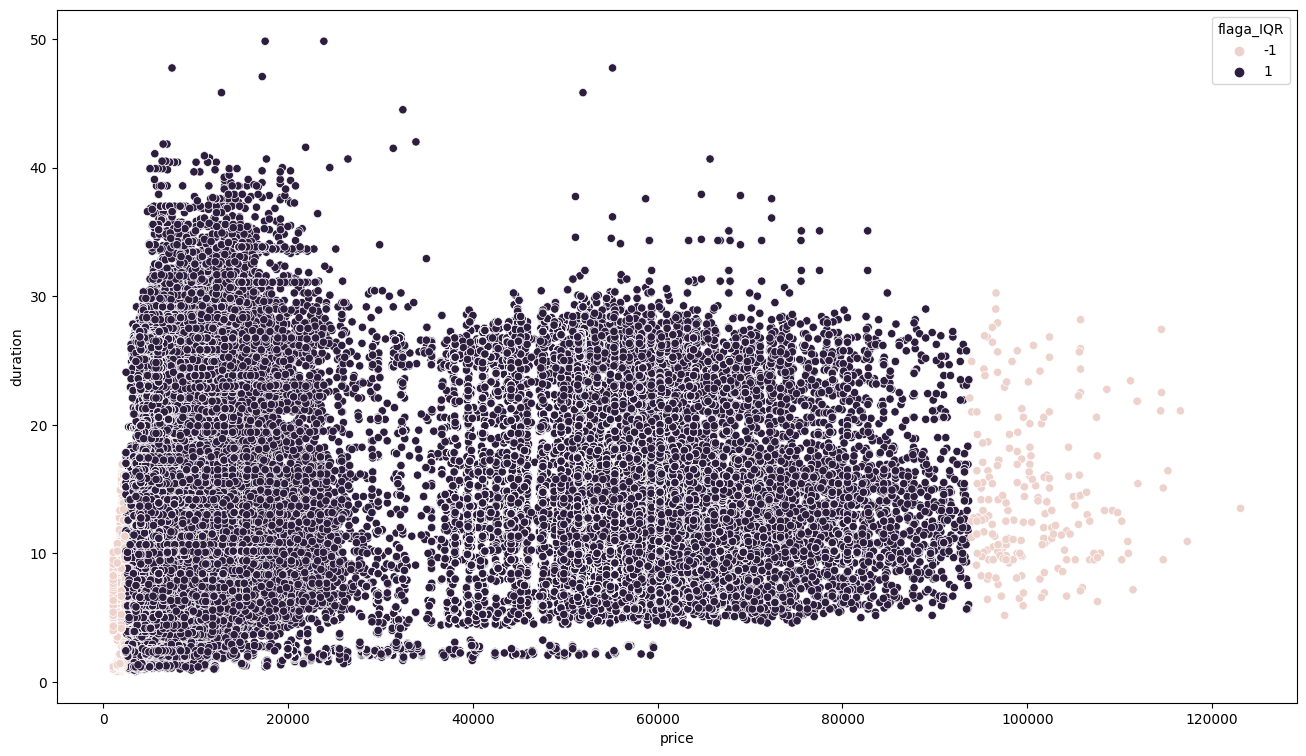

In [30]:
#co zostało usunięte?

dane_modelowanie_2["flaga_IQR"] = IQR_outliers_2(dane_modelowanie_2["duration"])
print(dane_modelowanie_2["flaga_IQR"])
sns.scatterplot(dane_modelowanie,
           x = "price",
           y = "duration",
           hue = "flaga_IQR")

In [31]:
dane_modelowanie_3 = dane_modelowanie_2[dane_modelowanie_2["flaga_IQR"]==1]
dane_modelowanie_3.shape

(284549, 12)

In [32]:
dane_modelowanie_3.shape

(284549, 12)

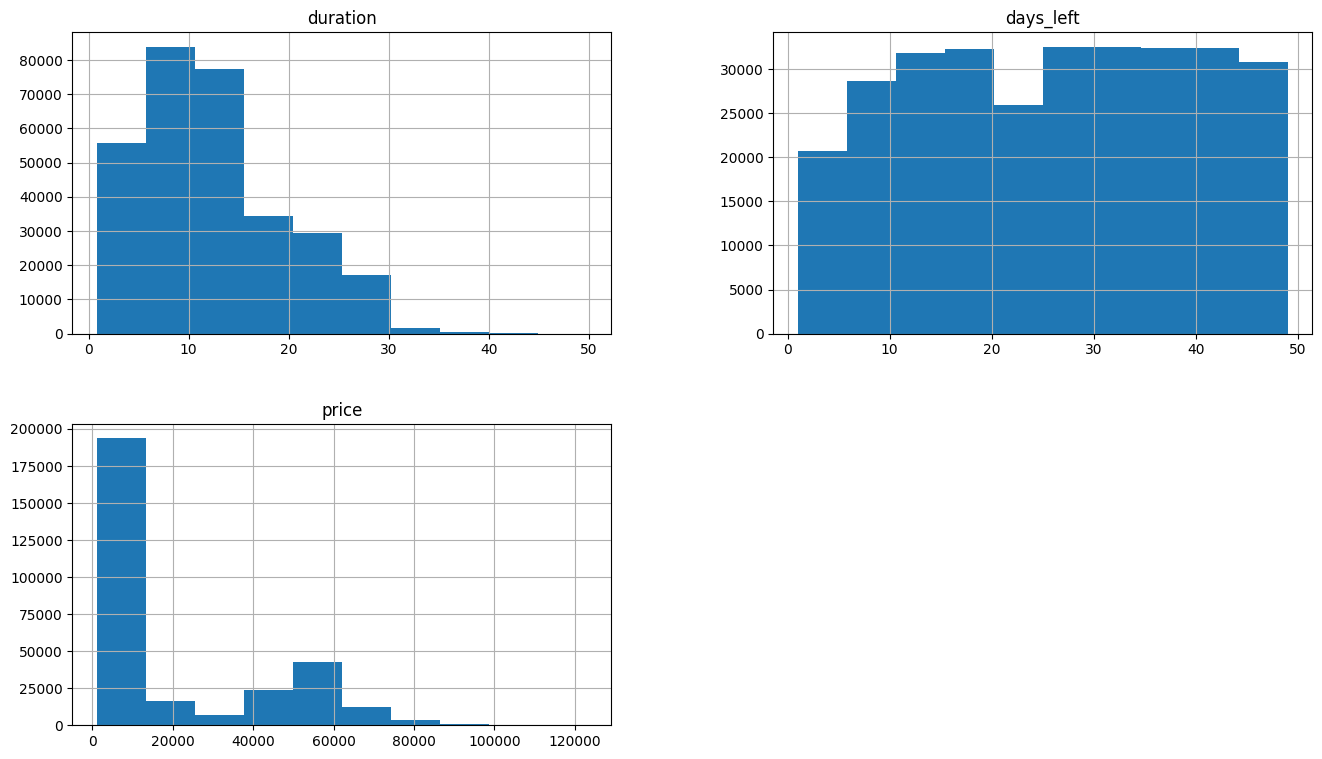

In [33]:
# rozkład przed usunięciem wartości odstających
dane_modelowanie.drop(columns=["flaga_IQR"]).hist(bins=10);

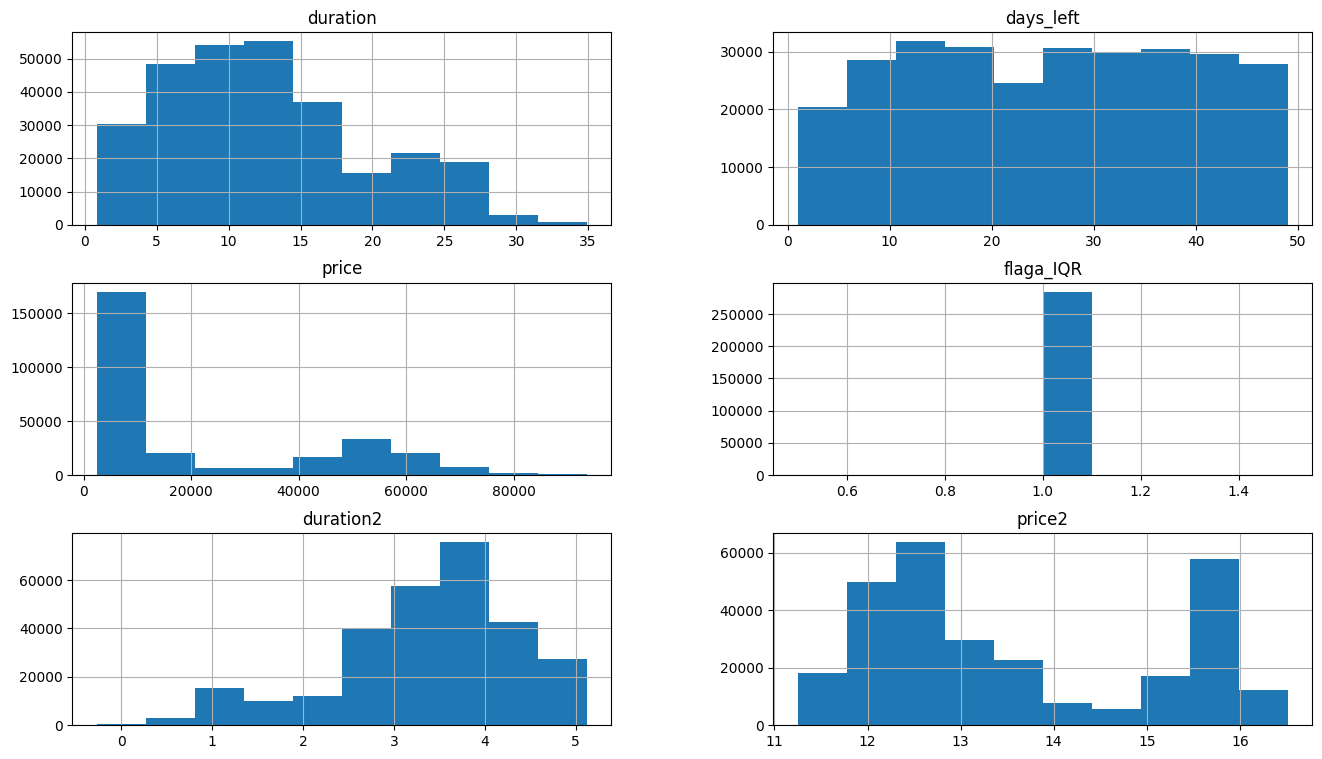

In [99]:
# rozkład po usunięciu wartości odstających
dane_modelowanie_3.hist(bins=10);

In [36]:
dane_modelowanie_3["duration2"] = np.log2(dane_modelowanie_3["duration"])
dane_modelowanie_3["price2"] = np.log2(dane_modelowanie_3["price"])

<ipython-input-36-726d8f03940c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-36-726d8f03940c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



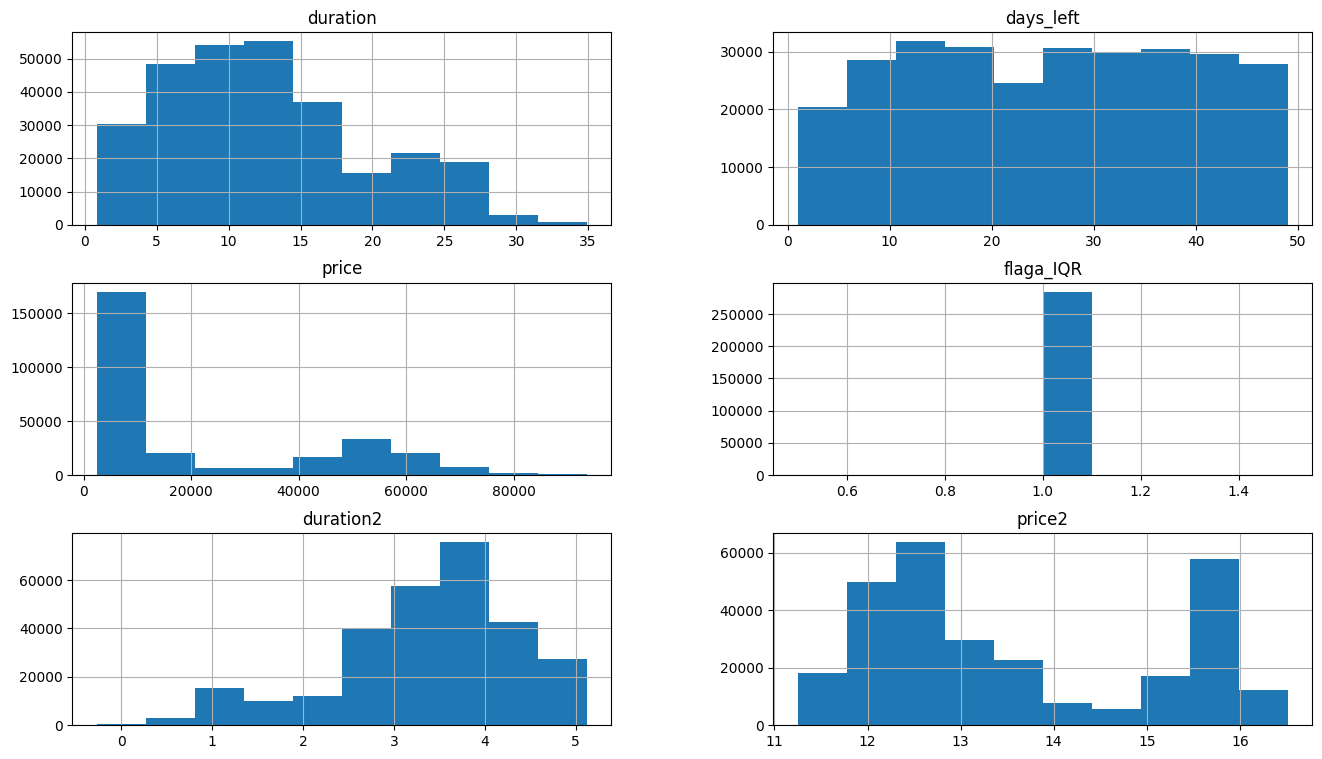

In [37]:
# rozkład po zlogarytmowaniu cech nienormalnych

dane_modelowanie_3.hist(bins=10);

<ipython-input-38-fdfe1cd9ca7a>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



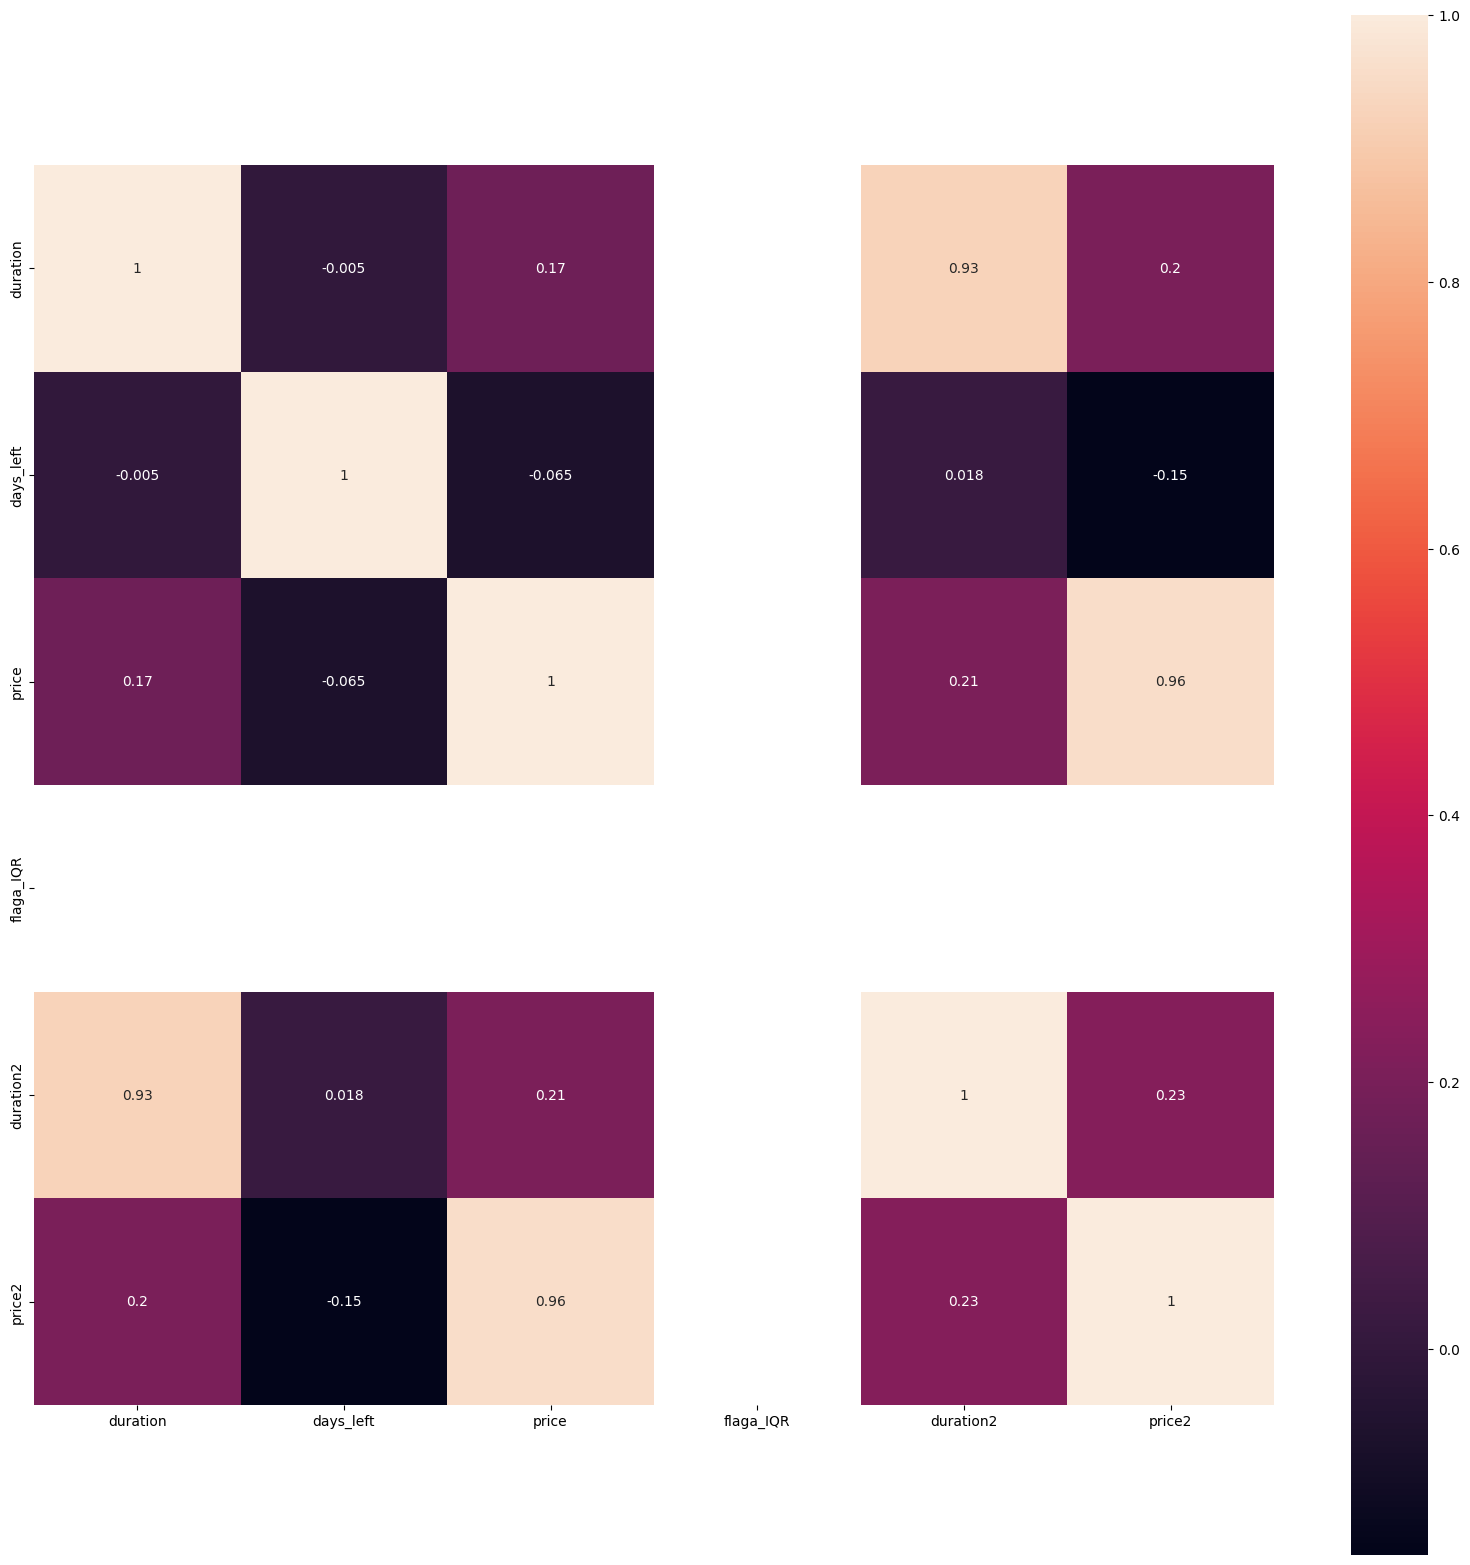

In [38]:
# sprawdzenie korelacji między zmiennymi
korelacja = dane_modelowanie_3.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(korelacja, square = True, annot = True);

In [39]:
dane_modelowanie_4 = pd.get_dummies(dane_modelowanie_3, columns=["airline",	"source_city",	"departure_time", "stops",	"arrival_time",	"destination_city",	"class"], prefix_sep="_")
dane_modelowanie_4

flight  duration  days_left  price  flaga_IQR  duration2     price2  \
0       SG-8709      2.17          1   5953          1   1.117695  12.539401   
1       SG-8157      2.33          1   5953          1   1.220330  12.539401   
2        I5-764      2.17          1   5956          1   1.117695  12.540128   
3        UK-995      2.25          1   5955          1   1.169925  12.539886   
4        UK-963      2.33          1   5955          1   1.220330  12.539886   
...         ...       ...        ...    ...        ...        ...        ...   
300148   UK-822     10.08         49  69265          1   3.333424  16.079839   
300149   UK-826     10.42         49  77105          1   3.381283  16.234537   
300150   UK-832     13.83         49  79099          1   3.789729  16.271372   
300151   UK-828     10.00         49  81585          1   3.321928  16.316016   
300152   UK-822     10.08         49  81585          1   3.333424  16.316016   

        airline_AirAsia  airline_Air_India  airline_GO_FIRST  ...  \
0                     0                  0                 0  ...   
1                     0                  0                 0  ...   
2                     1                  0                 0  ...   
3                     0                  0                 0  ...   
4                     0                  0                 0  ...   
...                 ...                ...               ...  ...   
300148                0                  0                 0  ...   
300149                0                  0                 0  ...   
300150                0                  0                 0  ...   
300151                0                  0                 0  ...   
300152                0                  0                 0  ...   

        arrival_time_Morning  arrival_time_Night  destination_city_Bangalore  \
0                          0                   1                           0   
1                          1                   0                           0   
2                          0                   0                           0   
3                          0                   0                           0   
4                          1                   0                           0   
...                      ...                 ...                         ...   
300148                     0                   0                           0   
300149                     0                   1                           0   
300150                     0                   1                           0   
300151                     0                   0                           0   
300152                     0                   0                           0   

        destination_city_Chennai  destination_city_Delhi  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
...                          ...                     ...   
300148                         0                       0   
300149                         0                       0   
300150                         0                       0   
300151                         0                       0   
300152                         0                       0   

        destination_city_Hyderabad  destination_city_Kolkata  \
0                                0                         0   
1                                0                         0   
2                                0                         0   
3                                0                         0   
4                                0                         0   
...                            ...                       ...   
300148                           1                         0   
300149                   

In [40]:
dane_modelowanie_5 = dane_modelowanie_4.drop(['flight', "flaga_IQR", "duration", "class_Economy", "price2"], axis = 1)
dane_modelowanie_5

days_left  price  duration2  airline_AirAsia  airline_Air_India  \
0               1   5953   1.117695                0                  0   
1               1   5953   1.220330                0                  0   
2               1   5956   1.117695                1                  0   
3               1   5955   1.169925                0                  0   
4               1   5955   1.220330                0                  0   
...           ...    ...        ...              ...                ...   
300148         49  69265   3.333424                0                  0   
300149         49  77105   3.381283                0                  0   
300150         49  79099   3.789729                0                  0   
300151         49  81585   3.321928                0                  0   
300152         49  81585   3.333424                0                  0   

        airline_GO_FIRST  airline_Indigo  airline_SpiceJet  airline_Vistara  \
0                      0               0                 1                0   
1                      0               0                 1                0   
2                      0               0                 0                0   
3                      0               0                 0                1   
4                      0               0                 0                1   
...                  ...             ...               ...              ...   
300148                 0               0                 0                1   
300149                 0               0                 0                1   
300150                 0               0                 0                1   
300151                 0               0                 0                1   
300152                 0               0                 0                1   

        source_city_Bangalore  ...  arrival_time_Late_Night  \
0                           0  ...                        0   
1                           0  ...                        0   
2                           0  ...                        0   
3                           0  ...                        0   
4                           0  ...                        0   
...                       ...  ...                      ...   
300148                      0  ...                        0   
300149                      0  ...                        0   
300150                      0  ...                        0   
300151                      0  ...                        0   
300152                      0  ...                        0   

        arrival_time_Morning  arrival_time_Night  destination_city_Bangalore  \
0                          0                   1                           0   
1                          1                   0                           0   
2                          0                   0                           0   
3                          0                   0                           0   
4                          1                   0                           0   
...                      ...                 ...                         ...   
300148                     0                   0                           0   
300149                     0                   1                           0   
300150                     0                   1                           0   
300151                     0                   0                           0   
300152                     0                   0                           0   

        destination_city_Chennai  destination_city_Delhi  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
...                          ...                     ...   
300148              

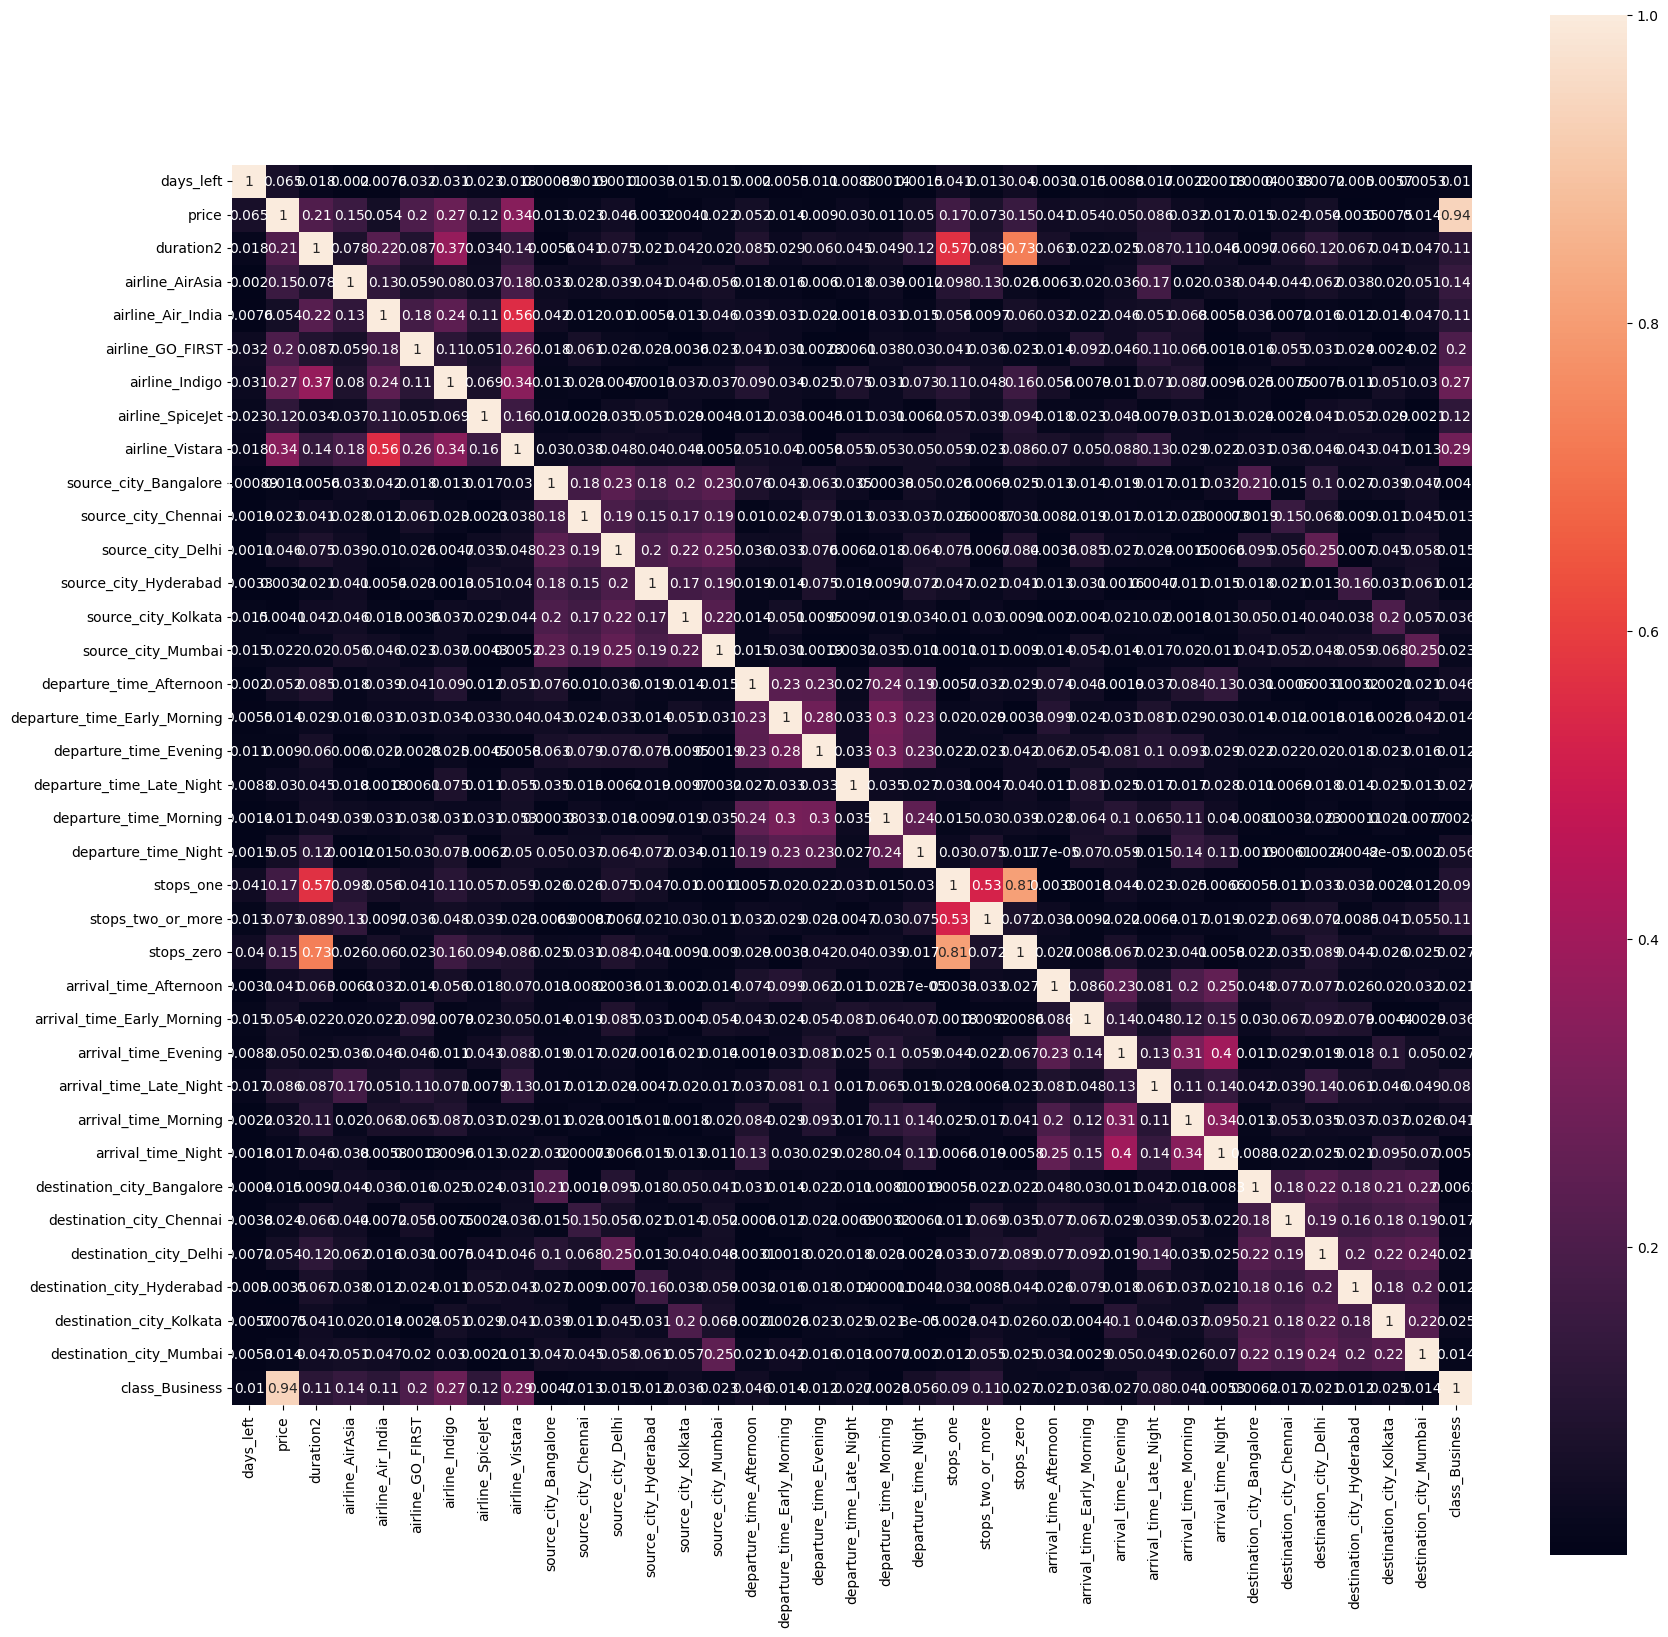

In [41]:
# sprawdzenie korelacji między zmiennymi - całkowita
korelacja = dane_modelowanie_5.corr().abs()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(korelacja, square = True, annot = True);

Tutaj następuje proces przygotowywania danych do uczenia


In [95]:
# tworzenie zbiorów
X = dane_modelowanie_5.drop(columns = ["price"])
y = dane_modelowanie_5["price"]

# tworzenie zbiorów uczący i testowy
X_uczacy, X_testowy, y_uczacy, y_testowy = model_selection.train_test_split(X,
                                                                            y.values,
                                                                            test_size = .2,
                                                                            random_state = 42)

In [43]:
X_uczacy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227639 entries, 238148 to 131789
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   days_left                     227639 non-null  int64  
 1   duration2                     227639 non-null  float64
 2   airline_AirAsia               227639 non-null  uint8  
 3   airline_Air_India             227639 non-null  uint8  
 4   airline_GO_FIRST              227639 non-null  uint8  
 5   airline_Indigo                227639 non-null  uint8  
 6   airline_SpiceJet              227639 non-null  uint8  
 7   airline_Vistara               227639 non-null  uint8  
 8   source_city_Bangalore         227639 non-null  uint8  
 9   source_city_Chennai           227639 non-null  uint8  
 10  source_city_Delhi             227639 non-null  uint8  
 11  source_city_Hyderabad         227639 non-null  uint8  
 12  source_city_Kolkata           227639 no

In [44]:
X_testowy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56910 entries, 121505 to 104172
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   days_left                     56910 non-null  int64  
 1   duration2                     56910 non-null  float64
 2   airline_AirAsia               56910 non-null  uint8  
 3   airline_Air_India             56910 non-null  uint8  
 4   airline_GO_FIRST              56910 non-null  uint8  
 5   airline_Indigo                56910 non-null  uint8  
 6   airline_SpiceJet              56910 non-null  uint8  
 7   airline_Vistara               56910 non-null  uint8  
 8   source_city_Bangalore         56910 non-null  uint8  
 9   source_city_Chennai           56910 non-null  uint8  
 10  source_city_Delhi             56910 non-null  uint8  
 11  source_city_Hyderabad         56910 non-null  uint8  
 12  source_city_Kolkata           56910 non-null  uint8  


In [45]:
print(y_uczacy)

[53634  4294  9716 ...  3860  4387  5715]


In [46]:
# standaryzowanie cech objaśniających
standaryzacja = preprocessing.StandardScaler()
fit_stand = standaryzacja.fit(X_uczacy)
X_uczacy_stand = fit_stand.transform(X_uczacy)
X_testowy_stand = fit_stand.transform(X_testowy)

W tej sekcji następuje nauka kilku modeli.

1) Regresja liniowa

2) Drzewo decyzyjne

3) XGBoost

4) Las losowy

In [51]:
# przygotowanie modelu Regresji Liniowej
model_rl = linear_model.LinearRegression()
model_rl.fit(X_uczacy_stand, y_uczacy)
predykcja_model_rl = model_rl.predict(X_testowy_stand)
rl_mse = metrics.mean_squared_error(y_testowy, predykcja_model_rl)
print("MSE - LinearRegression: ", rl_mse)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
rl_rmse = np.sqrt(rl_mse)
print("RMSE - LinearRegression: ", rl_rmse)

MSE - LinearRegression:  45105383.143690266
RMSE - LinearRegression:  6716.0541349582845


In [91]:
## tworzenie procesu standaryzacji i doboru modelu przy każdym podziale walidacji krzyżowej
# utworzenie metody standaryzacji danych
standaryzacja = preprocessing.StandardScaler()

# wybranie metody modelowania
algo = tree.DecisionTreeRegressor(random_state=42)

# utworzenie procesu standaryzacji i wykorzystania algorytmu drzew decyzyjnych
proces = pipeline.make_pipeline(standaryzacja, algo)

# zdefiniowanie metody walidacji modelu
walidacja = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# krzyżowa walidacja modelu DecisionTreeRegressor ze sprawdzeniem niegatywnego błędu średniokwadratowego - MSE
walidacja_neg_MSE_dtr = model_selection.cross_val_score(proces,
                                                        X_uczacy,
                                                        y_uczacy,
                                                        cv = walidacja,
                                                        scoring = "neg_mean_squared_error",
                                                        n_jobs = -1)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
# "-" bo MSE wyliczona jako wartość niegatywna
walidacja_RMSE_dtr = np.sqrt(-walidacja_neg_MSE_dtr)

algo.fit(X_uczacy, y_uczacy)

# podsumowanie dla DecisionTreeRegressor
print("Średnia wartość RMSE - DecisionTreeRegressor: ", walidacja_RMSE_dtr.mean())
print("Mediana wartość RMSE - DecisionTreeRegressor: ", np.median(walidacja_RMSE_dtr))
print("Odchylenie standardowe RMSE - DecisionTreeRegressor: ", walidacja_RMSE_dtr.std())

Średnia wartość RMSE - DecisionTreeRegressor:  3467.154626798125
Mediana wartość RMSE - DecisionTreeRegressor:  3481.0196852990275
Odchylenie standardowe RMSE - DecisionTreeRegressor:  65.95829919334948


In [96]:
bst = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# fit model
bst.fit(X_uczacy, y_uczacy)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [67]:
# define model evaluation method
cv = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
# evaluate model
scores = model_selection.cross_val_score(bst, X_uczacy, y_uczacy, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# walidacja
walidacja_RMSE_dtr = np.sqrt(-scores)

# podsumowanie dla XGBRegressor
print("Średnia wartość RMSE - XGBRegressor: ", walidacja_RMSE_dtr.mean())
print("Mediana wartość RMSE - XGBRegressor: ", np.median(walidacja_RMSE_dtr))
print("Odchylenie standardowe RMSE - XGBRegressor: ", walidacja_RMSE_dtr.std())

Średnia wartość RMSE - XGBRegressor:  38.50540420059795
Mediana wartość RMSE - XGBRegressor:  38.42772433786775
Odchylenie standardowe RMSE - XGBRegressor:  0.16244011131473682


In [71]:
# względna istotność cech wykorzystanych do modelowania
istotnosc_cech_modelu = pd.DataFrame(dict(istotnosc=bst.feature_importances_,
                                          cecha=X_uczacy.columns.values)).sort_values(by="istotnosc", ascending=False)

# wizualizacja istotności cech
px.pie(istotnosc_cech_modelu,
       values= "istotnosc",
       names = "cecha",
       title = "Względna istotność cech wykorzystywanych w modelu CGBoost")

Nie wiem czemu ten wykres mi nie wyszedł, ale nie wiedziałem już jak go naprawić :<

Na szczęście wniosek jest dość jasny: najważniejszymi cechami jest to czy ktoś lata klasą biznesową oraz to, czy nie ma przesiadek między miastem startowym a docelowym


Swoją drogą RMSE wynosi tutaj tylko około 40 rupli.

In [73]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_uczacy, y_uczacy)

RandomForestRegressor(max_depth=2, random_state=0)

In [75]:
# define model evaluation method
cv = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
# evaluate model
scores = model_selection.cross_val_score(regr, X_uczacy, y_uczacy, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

walidacja_RMSE_dtr = np.sqrt(-scores)

# podsumowanie dla RandomForestRegressor
print("Średnia wartość RMSE - RandomForestRegressor: ", walidacja_RMSE_dtr.mean())
print("Mediana wartość RMSE - RandomForestRegressor: ", np.median(walidacja_RMSE_dtr))
print("Odchylenie standardowe RMSE - RandomForestRegressor: ", walidacja_RMSE_dtr.std())

Średnia wartość RMSE - RandomForestRegressor:  62.151844958704764
Mediana wartość RMSE - RandomForestRegressor:  62.086985663061405
Odchylenie standardowe RMSE - RandomForestRegressor:  0.14076430992049999


In [76]:
# względna istotność cech wykorzystanych do modelowania
istotnosc_cech_modelu = pd.DataFrame(dict(istotnosc=regr.feature_importances_,
                                          cecha=X_uczacy.columns.values)).sort_values(by="istotnosc", ascending=False)

# wizualizacja istotności cech
px.pie(istotnosc_cech_modelu,
       values= "istotnosc",
       names = "cecha",
       title = "Względna istotność cech wykorzystywanych w modelu RandomForestRegressor")

Wnioski podobne jak wyżej, jednak tutaj wybija się również cecha "czas trwania lotu".

### Bardzo chciałem móc zrobić porządny model Random Forest i przeszukwianiem siatki parametrów, ale niestety ten zbiór danych (300 tysięcy rekordów) zabił mój komputer, oraz zabił też Colaba.

###Niemniej zawsze gdy tylko mam możliwość (w rozumieniu mocy obliczeniowej) chcę spróbować uczenia zespołowego, gdyż jest ono najbardziej efektywne.

In [80]:
# zapisanie wytrenowanego najlepszego modelu
joblib.dump(bst, "XGBoost_v1.pkl")

['XGBoost_v1.pkl']

In [93]:
y_pred = bst.predict(X_testowy)
rms = sqrt(mean_squared_error(y_testowy, y_pred))
print(rms)

2591.454220705809


## Zapisałem model oraz wyliczyłem RMSE jego predykcji dla najlepszego modelu (XGB).

## Zła wiadomość jest taka, że błąd wynosi już nie 40, a około 2500 rupli. To spora różnica, która może wskazywać, że model jest przetrenowany na danych uczących. Być może należało by jakoś inaczej przekształcić dane, albo wyuczyć go na mniejszym zestawei danych. Być może uczenie zespołowe z metodą głosowania twardego byłoby też dobrym pomysłem, ale na to niestety nie mam obecnie mocy obliczeniowej.

## Dobra wiadomość za to jest taka, że błąd wynosi około 2500 rupli, więc mieścimy się w założeniach początkowych, więc zadanie uznaję za zakończone sukcesem. :)